In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Part 1: Price Prediction

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
# Start by doing the wrong thing - predicting the price itself
series = df['close'].values.reshape(-1, 1)

In [4]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [5]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [6]:
# try autoregressive RNN model
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0)) 

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [7]:
model = RNN(1, 5, 1, 1)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)
model.to(device)

device: cuda:0


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [10]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            Y_train,
            X_test,
            Y_test,
            epochs=200):

    # stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)

        # backward and optimize
        loss.backward()
        optimizer.step()

        # Save the loss
        train_losses[it] = loss.item()

        # Test Loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, Y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [11]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
Y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
Y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [12]:
# Move to GPU
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [13]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, Y_train, X_test, Y_test)

Epoch 10/200, Train Loss: 0.0951, Test Loss: 0.2030
Epoch 20/200, Train Loss: 0.0244, Test Loss: 0.1465
Epoch 30/200, Train Loss: 0.0119, Test Loss: 0.0221
Epoch 40/200, Train Loss: 0.0074, Test Loss: 0.0679
Epoch 50/200, Train Loss: 0.0060, Test Loss: 0.0288
Epoch 60/200, Train Loss: 0.0056, Test Loss: 0.0346
Epoch 70/200, Train Loss: 0.0054, Test Loss: 0.0257
Epoch 80/200, Train Loss: 0.0053, Test Loss: 0.0257
Epoch 90/200, Train Loss: 0.0053, Test Loss: 0.0254
Epoch 100/200, Train Loss: 0.0052, Test Loss: 0.0231
Epoch 110/200, Train Loss: 0.0052, Test Loss: 0.0225
Epoch 120/200, Train Loss: 0.0051, Test Loss: 0.0224
Epoch 130/200, Train Loss: 0.0051, Test Loss: 0.0218
Epoch 140/200, Train Loss: 0.0051, Test Loss: 0.0212
Epoch 150/200, Train Loss: 0.0051, Test Loss: 0.0207
Epoch 160/200, Train Loss: 0.0051, Test Loss: 0.0204
Epoch 170/200, Train Loss: 0.0051, Test Loss: 0.0202
Epoch 180/200, Train Loss: 0.0051, Test Loss: 0.0202
Epoch 190/200, Train Loss: 0.0050, Test Loss: 0.0202
Ep

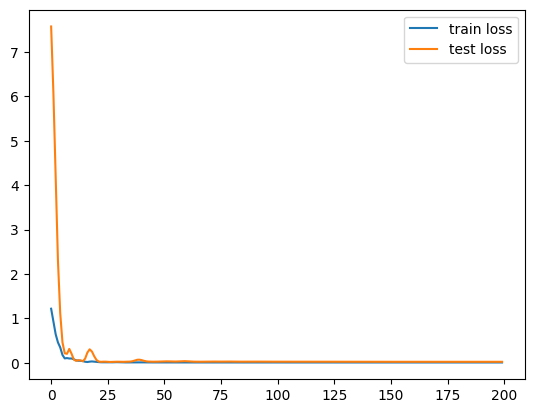

In [14]:
# Plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [15]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# Index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].view(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

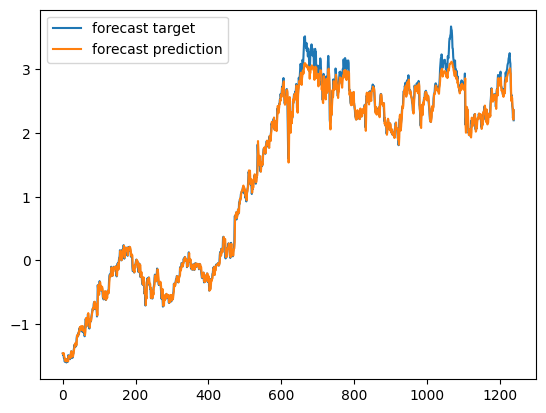

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [17]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

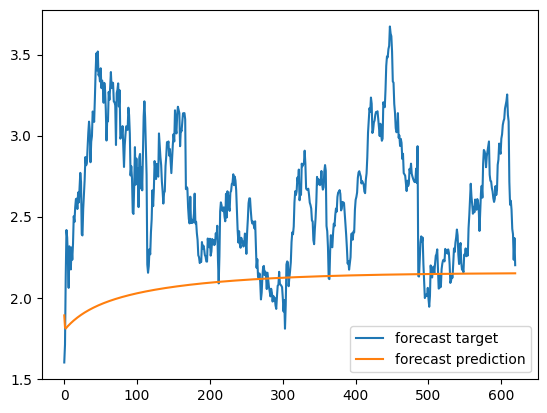

In [18]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

## Part 2: Returns

In [19]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # shift up by 1

# so now it's like
# Close / PrevClose
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [20]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [21]:
# then the return is 
# (x[t] - x[t-1]) / x[t-1]

df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


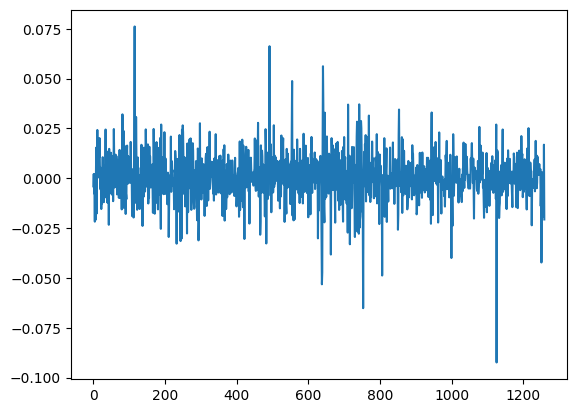

In [22]:
plt.plot(df['Return'])
plt.show()

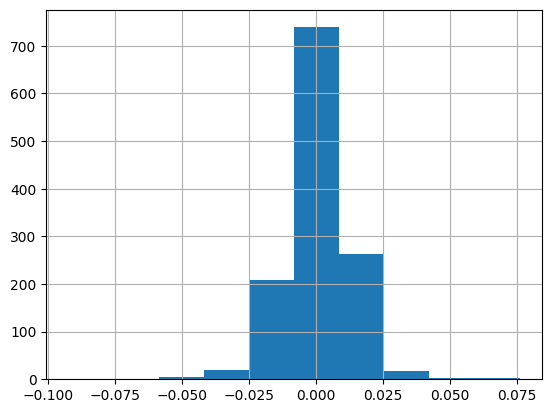

In [23]:
# now let's try an LSTM to predict the return
df['Return'].hist()
plt.show()

In [24]:
series = df['Return'].values[1:].reshape(-1, 1) 

# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [25]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now it's N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [26]:
# try autoregressive RNN model
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [28]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
Y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
Y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [29]:
# move to GPU
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [30]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, Y_train, X_test, Y_test)

Epoch 10/200, Train Loss: 1.0499, Test Loss: 1.0732
Epoch 20/200, Train Loss: 1.0386, Test Loss: 1.0922
Epoch 30/200, Train Loss: 1.0260, Test Loss: 1.1050
Epoch 40/200, Train Loss: 1.0108, Test Loss: 1.1240
Epoch 50/200, Train Loss: 0.9930, Test Loss: 1.1390
Epoch 60/200, Train Loss: 0.9710, Test Loss: 1.1858
Epoch 70/200, Train Loss: 0.9628, Test Loss: 1.2614
Epoch 80/200, Train Loss: 0.9290, Test Loss: 1.2314
Epoch 90/200, Train Loss: 0.8929, Test Loss: 1.2806
Epoch 100/200, Train Loss: 0.8677, Test Loss: 1.3921
Epoch 110/200, Train Loss: 0.8723, Test Loss: 1.4650
Epoch 120/200, Train Loss: 0.8612, Test Loss: 1.4441
Epoch 130/200, Train Loss: 0.8533, Test Loss: 1.3676
Epoch 140/200, Train Loss: 0.8129, Test Loss: 1.4294
Epoch 150/200, Train Loss: 0.7954, Test Loss: 1.6378
Epoch 160/200, Train Loss: 0.8715, Test Loss: 1.3444
Epoch 170/200, Train Loss: 0.8356, Test Loss: 1.4173
Epoch 180/200, Train Loss: 0.7975, Test Loss: 1.6931
Epoch 190/200, Train Loss: 0.8190, Test Loss: 1.7874
Ep

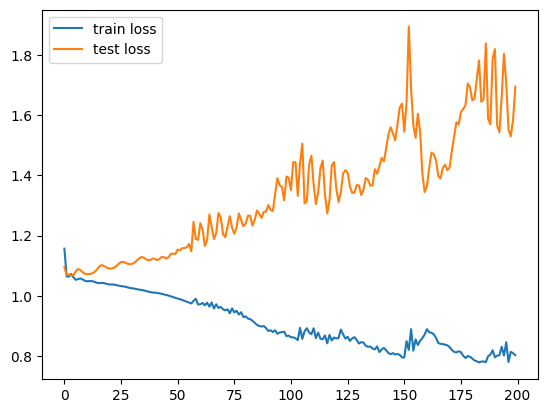

In [31]:
# plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [32]:
# one-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].view(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

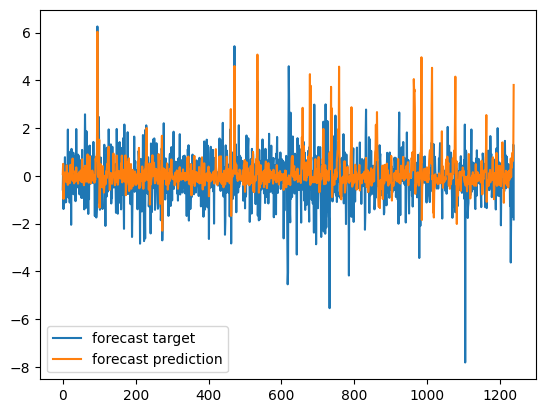

In [33]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [34]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

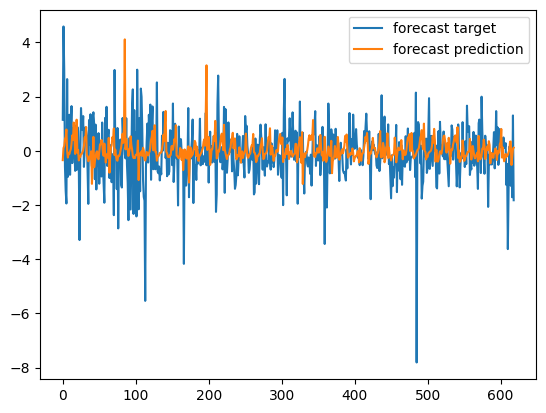

In [35]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

## Part 3: Binary Classification

In [36]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [37]:
# Now make the actual data which will go into the nerual network
T = 10
D = input_data.shape[1] 
N = len(input_data) - T

In [38]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [39]:
# Setup X and Y train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
    X_train[t,:,:] = input_data[t:t+T]
    Y_train[t] = (targets[t+T] > 0)

In [40]:
# Setup X and Y test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u,:,:] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

In [41]:
# Make the RNN
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [42]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [43]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
Y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
Y_test = torch.from_numpy(Y_test.astype(np.float32))

In [44]:
# Move to GPU
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [45]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, Y_train, X_test, Y_test, epochs=300)

Epoch 10/300, Train Loss: 0.6913, Test Loss: 0.6925
Epoch 20/300, Train Loss: 0.6854, Test Loss: 0.6936
Epoch 30/300, Train Loss: 0.6763, Test Loss: 0.7111
Epoch 40/300, Train Loss: 0.6548, Test Loss: 0.7129
Epoch 50/300, Train Loss: 0.6366, Test Loss: 0.7321
Epoch 60/300, Train Loss: 0.5900, Test Loss: 0.7533
Epoch 70/300, Train Loss: 0.5607, Test Loss: 0.7808
Epoch 80/300, Train Loss: 0.4788, Test Loss: 0.8897
Epoch 90/300, Train Loss: 0.4568, Test Loss: 1.0456
Epoch 100/300, Train Loss: 0.4029, Test Loss: 1.1907
Epoch 110/300, Train Loss: 0.3575, Test Loss: 1.1566
Epoch 120/300, Train Loss: 0.3203, Test Loss: 1.4173
Epoch 130/300, Train Loss: 0.2974, Test Loss: 1.5228
Epoch 140/300, Train Loss: 0.2563, Test Loss: 1.5733
Epoch 150/300, Train Loss: 0.2229, Test Loss: 1.7936
Epoch 160/300, Train Loss: 0.2122, Test Loss: 1.9269
Epoch 170/300, Train Loss: 0.1771, Test Loss: 2.1031
Epoch 180/300, Train Loss: 0.1410, Test Loss: 2.2058
Epoch 190/300, Train Loss: 0.1168, Test Loss: 2.4249
Ep

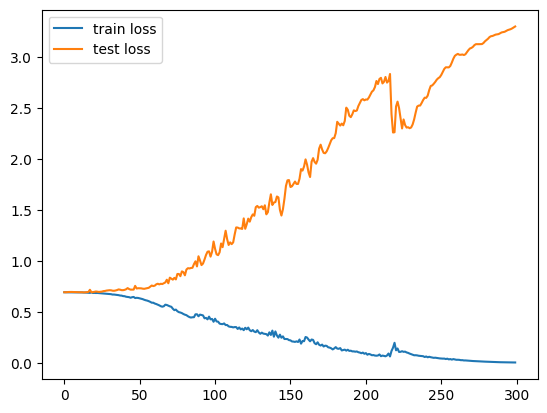

In [46]:
# Plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [48]:
# Get accuracy
with torch.no_grad():
    p_train = model(X_train)
    p_train = (p_train.cpu().numpy() > 0)
    train_acc = np.mean(Y_train.cpu().numpy() == p_train)

    p_test = model(X_test)
    p_test = (p_test.cpu().numpy() > 0)
    test_acc = np.mean(Y_test.cpu().numpy() == p_test)

print(f"Train acc: {train_acc:.4f}, test acc: {test_acc:.4f}")

Train acc: 1.0000, test acc: 0.5000
